In [2]:
import pandas as pd

from tqdm.auto import tqdm
tqdm.pandas()

## Данные

собираю примеры из нескольких отдельных файлов

In [3]:
contrast_df = pd.read_csv('Data\contrast_examples.tsv', sep='\t')
cause_df = pd.read_csv('Data\cause_examples.tsv', sep='\t')

In [4]:
df1 = contrast_df[contrast_df['подходит?']=='да'].drop(columns=['подходит?'])
df1['relation'] = 'contrast'
df1['есть маркер?'] = 'нет'
df1['id'] = df1['id']+1
df1.head()

,id,текст,relation,есть маркер?
0,407,"В солнечный день, наверное, и вода играет друг...",contrast,нет
2,921,там никто не в курсе никаких автобусов_говорят...,contrast,нет
3,1051,В каком-то проёме за щёлкой эти монетки и оста...,contrast,нет
4,1067,"Что ни говори, общий относительно приличный ур...",contrast,нет
5,1161,"Коробка красивая,_прибор явно туфтовый, даже п...",contrast,нет


In [5]:
df2 = cause_df
df2['relation'] = 'cause'
df2.head()

,id,есть маркер?,текст,relation
0,24,нет,"Помада довольно стойкая,_отлично переживет пер...",cause
1,41,да,Поскольку кремовых румян у меня не было никаки...,cause
2,54,да,Благодаря достаточной пигментированности_хвати...,cause
3,57,да,Сверху кремовые текстуры я всегда перекрываю п...,cause
4,71,да,"Популярная идея микробиома, косметики с про/пр...",cause


склеиваю два датафрейма и проверяю, что нигде ничего не потерялось (нет пустых значений)

In [6]:
all_data = pd.concat([df1, df2], ignore_index=True)
all_data.isna().any()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


id              False
relation        False
есть маркер?    False
текст           False
dtype: bool

Разделяю пример на две ЭДЕ по `_`

In [7]:
new_df = all_data['текст'].str.split('_',expand=True)
new_df = new_df.rename(columns={0:'эде1', 1:'эде2'})
all_data = pd.concat([ all_data, new_df[['эде1', 'эде2']] ], axis=1)
all_data.head()

,id,relation,есть маркер?,текст,эде1,эде2
0,407,contrast,нет,"В солнечный день, наверное, и вода играет друг...","В солнечный день, наверное, и вода играет друг...","Главное, что это не повод сидеть дома,"
1,921,contrast,нет,там никто не в курсе никаких автобусов_говорят...,там никто не в курсе никаких автобусов,говорят; что всё на автостанцию приходит.
2,1051,contrast,нет,В каком-то проёме за щёлкой эти монетки и оста...,В каком-то проёме за щёлкой эти монетки и оста...,И даже никаких чеков автомат не выдаёт.
3,1067,contrast,нет,"Что ни говори, общий относительно приличный ур...","Что ни говори, общий относительно приличный ур...",Автобусный транспорт реально много где на уров...
4,1161,contrast,нет,"Коробка красивая,_прибор явно туфтовый, даже п...","Коробка красивая,","прибор явно туфтовый, даже по внешнему виду."


# Признаки

считаю все признаки, которые можно получить автоматически

## Длины

Токенизирую тексты и считаю следующие параметры (учитывая только слова, без пунктуации):

`n_words` - кол-во слов в каждой ЭДЕ

`av_words_length` - средняя длина слова в каждой ЭДЕ

`n_words_diff` - разница в кол-вах между словами (знак показывает, какая из ЭДЕ длинее)

In [8]:
import re
from razdel import tokenize

In [9]:
def tokenizer(text_data):
    tokens = [_.text for _ in list(tokenize(str(text_data).lower()))] #if not re.search('[^а-яА-ЯёЁa-zA-z]', _.text)]
    return " ".join(tokens)

def get_words(tokens):
    words = [token for token in tokens.split() if not re.search('[^а-яА-ЯёЁa-zA-z]', token)]
    return " ".join(words)

def count_words(words):
    return len(words.split())

def av_word_length(words):
    l = [len(word) for word in words.split()]
    return sum(l)/len(l)

In [10]:
for i in ['1', '2']:
    all_data['tokens'+i] = all_data['эде'+i].progress_apply(tokenizer)
    all_data['words'+i] = all_data['tokens'+i].progress_apply(get_words)
    all_data['n_words'+i] = all_data['words'+i].progress_apply(count_words)
    all_data['av_words_length'+i] = all_data['words'+i].progress_apply(av_word_length)

In [11]:
all_data['n_words_diff'] = all_data['n_words1'] - all_data['n_words2']

## Пунктуация между ЭДЕ

`punct` - знак препинания между двумя ЭДЕ (беру последний токен первой ЭДЕ). _None_ если знаков там нет. Данные заранее нормализованы вручную так, чтобы знак оставался в первом эелементе. 

In [12]:
def find_punct(tokens):
    last = tokens[-1]
    if last not in ['.', ',', ':', '-', '?', ')', '…']:
        last = 'none'
        
    return last

all_data['punct'] = all_data['tokens1'].apply(find_punct)
all_data['if punct'] = (all_data['punct'] != 'none')

## POS анализ

Считаю вектор со значениями всех чатей речи и разбиваю его на отдельные признаки

In [13]:
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

In [14]:
tag_list = ['ADJF', 'ADJS', 'ADVB', 'COMP', 'CONJ', 'GRND', 'INFN', 'INTJ', 'NOUN',
            'NPRO', 'NUMR', 'None', 'PRCL', 'PRED', 'PREP', 'PRTF', 'PRTS', 'VERB']

In [15]:
def count_POS(words):
    POS_dict = {'ADJF': 0,
                'ADJS': 0,
                'ADVB': 0,
                'COMP': 0,
                'CONJ': 0,
                'GRND': 0,
                'INFN': 0,
                'INTJ': 0,
                'NOUN': 0,
                'NPRO': 0,
                'NUMR': 0,
                'None': 0,
                'PRCL': 0,
                'PRED': 0,
                'PREP': 0,
                'PRTF': 0,
                'PRTS': 0,
                'VERB': 0}
    
    for word in words.split():
        p = morph.parse(word)[0]
        tag = p.tag.POS
        if tag is None:
            tag = 'None'
        POS_dict[tag] += 1
    return list(POS_dict.values())

In [16]:
for i in ['1', '2']:
    all_data['pos_vector'+i] = all_data['words'+i].progress_apply(count_POS)
    
    all_data[ [tag+i for tag in tag_list] ] = pd.DataFrame(all_data['pos_vector'+i].tolist())

## Повторяющиеся слова

Лемматизирую тексты и считаю сколько слов встречаются в обеих ЭДЕ

In [17]:
def lemmatizer(words):
    lem_text = []
    for word in words.split():
        lem = morph.parse(word)[0].normal_form
#         if lem not in stops:
        lem_text.append(lem)
    return ' '.join(lem_text)

def similar_words(lemm_a, lemm_b):
    return list(set(lemm_a.split()) & set(lemm_b.split()))

In [18]:
for i in ['1', '2']:
    all_data['lemm'+i] = all_data['words'+i].progress_apply(lemmatizer)

In [19]:
all_data['similar_words'] = all_data.apply(lambda x: similar_words(x['lemm1'], x['lemm2']), axis=1)
all_data['n_similar_words'] = all_data['similar_words'].apply(len)

In [20]:
all_data[all_data['n_similar_words'] != 0]['similar_words']

2                                     [и]
3                    [уровень, транспорт]
9                                     [с]
11                               [бывать]
15                                  [кот]
18                               [писать]
20                                  [для]
21                             [хотеться]
22     [путь, результат, это, быстрый, к]
23                    [быть, пищеварение]
25                      [платить, тестер]
26                             [работать]
27                    [требовать, ресурс]
28                               [способ]
30                                  [что]
32                           [технология]
34                                   [не]
35                            [хотеть, я]
37                [сказать, мочь, я, что]
39                             [удобство]
41              [нужно, это, значит, что]
42            [союз, это, россия, и, что]
45                                  [они]
49                                

## Эмбединги

Обучаю модель, получаю вектора размерности 10 для каждой пары ЭДЕ и считаю их косинусную близовть. Вектора разбиваю на 10 отдельных признаков. Как дальше покажут эксперименты, если использовать эти 10 отдельных признаков, то почти все модели получаются сильно завязаны на каку-то их часть, при этом если их не использовать - качество не особо и меняется. Так что в итоге при обучении я буду использовать только значение близости между векторами двух ЭДЕ `cosine_d2v`.

### doc2vec

In [21]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [22]:
corpora = all_data['lemm1'].values.tolist() + all_data['lemm2'].values.tolist()
len(corpora)

324

In [23]:
documents = [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(corpora)]
model = Doc2Vec(documents, vector_size=10, window=2, min_count=1)

In [24]:
def get_d2v_vector(lemm):
    return model.infer_vector(lemm.split())

def cosine_d2v(lemm1, lemm2):
    return model.wv.n_similarity(lemm1.split(),lemm2.split())

In [25]:
for i in ['1', '2']:
    all_data['d2v_vector'+i] = all_data['lemm'+i].progress_apply(get_d2v_vector)
    all_data[ ['v'+str(n)+'_'+i for n in range(10)] ] = pd.DataFrame(all_data['d2v_vector'+i].tolist())

In [26]:
all_data['cosine_d2v'] = all_data.apply(lambda x: cosine_d2v(x['lemm1'], x['lemm2']), axis=1)

### Сохранение всех результатов экселе

In [27]:
all_data.to_excel('Data\data_full_markup.xlsx')

# Модели

In [28]:
import numpy as np
from sklearn.metrics import classification_report

## Обчающая и тестовая выборки

In [29]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [30]:
no_marker = all_data[all_data['есть маркер?'] == 'нет']

In [31]:
not_features = ['id', 'есть маркер?', 'текст',
                'эде1', 'эде2',
                'tokens1', 'tokens2',
                'words1', 'words2',
                'pos_vector1', 'pos_vector2',
                'lemm1', 'lemm2',
                'similar_words', 'if punct', 
                'd2v_vector1', 'd2v_vector2']

not_features.extend(['v'+str(n)+'_'+'1' for n in range(10)])
not_features.extend(['v'+str(n)+'_'+'2' for n in range(10)])

features = list(set(no_marker.columns.values.tolist()) - set(not_features))

data = no_marker.drop(columns=not_features)
data = data.apply(LabelEncoder().fit_transform) # 1 = contrast, 0 = cause

X = data.drop(columns=['relation'])
y = data['relation']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=42)

In [32]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88 entries, 90 to 114
Data columns (total 44 columns):
n_words1            88 non-null int64
av_words_length1    88 non-null int64
n_words2            88 non-null int64
av_words_length2    88 non-null int64
n_words_diff        88 non-null int64
punct               88 non-null int32
ADJF1               88 non-null int64
ADJS1               88 non-null int64
ADVB1               88 non-null int64
COMP1               88 non-null int64
CONJ1               88 non-null int64
GRND1               88 non-null int64
INFN1               88 non-null int64
INTJ1               88 non-null int64
NOUN1               88 non-null int64
NPRO1               88 non-null int64
NUMR1               88 non-null int64
None1               88 non-null int64
PRCL1               88 non-null int64
PRED1               88 non-null int64
PREP1               88 non-null int64
PRTF1               88 non-null int64
PRTS1               88 non-null int64
VERB1               8

## Логистическая регрессия

In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
lreg = LogisticRegression(random_state=42)
lreg.fit(X_train, y_train)

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
y_pred_lreg = lreg.predict(X_test)
print(classification_report(y_test, y_pred_lreg))

              precision    recall  f1-score   support

           0       0.64      0.58      0.61        12
           1       0.55      0.60      0.57        10

    accuracy                           0.59        22
   macro avg       0.59      0.59      0.59        22
weighted avg       0.60      0.59      0.59        22



In [36]:
feature_importances_lreg = lreg.coef_
for ind in np.argsort(-feature_importances_lreg[0]):
    print(X_train.columns[ind], '-', feature_importances_lreg[0][ind])

PRCL2 - 1.4670782677718803
VERB1 - 0.7772828592428411
NUMR1 - 0.6818007123886191
ADJS1 - 0.6788518303056905
ADVB1 - 0.6595502475731199
n_similar_words - 0.6199275073264818
INTJ2 - 0.5324387499921709
INTJ1 - 0.4771718004026744
PRED1 - 0.3792354053895994
PREP2 - 0.3757810231306586
ADJF1 - 0.36754742880029234
ADJF2 - 0.3596354072909244
PRCL1 - 0.2814309272581437
CONJ2 - 0.27427340907359693
punct - 0.19461736219874282
CONJ1 - 0.18846204185972232
None2 - 0.17586874015518325
INFN1 - 0.13512699719859309
NOUN1 - 0.11254048521310035
ADJS2 - 0.07755941423575269
PRTS2 - 0.06940401957366814
av_words_length1 - 0.01560699507197942
COMP1 - 0.007467531067098584
n_words1 - 0.006433042367618369
av_words_length2 - 0.0023954185477351175
PRTF2 - -0.0008136058322891148
cosine_d2v - -0.008373775290109034
NUMR2 - -0.03301137603387295
PRED2 - -0.043888467880762005
n_words_diff - -0.06244873990617853
NPRO2 - -0.08540993626795067
INFN2 - -0.101288566359321
ADVB2 - -0.14328995070267006
PREP1 - -0.1473364292394302

## Decision Tree

In [37]:
from sklearn.tree import DecisionTreeClassifier

In [38]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [39]:
y_pred_tree = tree_clf.predict(X_test)
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.70      0.70      0.70        10

    accuracy                           0.73        22
   macro avg       0.72      0.72      0.72        22
weighted avg       0.73      0.73      0.73        22



In [40]:
feature_importances_tree = tree_clf.feature_importances_
for ind in np.argsort(-feature_importances_tree):
    print(X_train.columns[ind], '-', feature_importances_tree[ind])

PRCL2 - 0.2157310081223126
av_words_length2 - 0.13685337598044553
cosine_d2v - 0.09605190430335142
n_words2 - 0.08534115987532133
n_words1 - 0.08003549245785271
VERB2 - 0.07707546786830673
ADVB2 - 0.05579710144927536
punct - 0.0557971014492753
NPRO1 - 0.03985507246376811
PREP1 - 0.03416149068322981
ADJF2 - 0.03416149068322981
INTJ1 - 0.03414119270896762
ADJF1 - 0.022774327122153208
ADVB1 - 0.018309880862475533
NPRO2 - 0.013913933970034919
GRND1 - 0.0
INFN2 - 0.0
INTJ2 - 0.0
NOUN2 - 0.0
NUMR2 - 0.0
None2 - 0.0
av_words_length1 - 0.0
PRED2 - 0.0
PREP2 - 0.0
PRTF2 - 0.0
PRTS2 - 0.0
GRND2 - 0.0
CONJ2 - 0.0
COMP2 - 0.0
ADJS1 - 0.0
ADJS2 - 0.0
n_words_diff - 0.0
VERB1 - 0.0
PRTS1 - 0.0
n_similar_words - 0.0
PRED1 - 0.0
PRCL1 - 0.0
None1 - 0.0
NUMR1 - 0.0
COMP1 - 0.0
NOUN1 - 0.0
INFN1 - 0.0
CONJ1 - 0.0
PRTF1 - 0.0


## Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
rf_clf = RandomForestClassifier(n_estimators=10, random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [43]:
y_pred_forest = rf_clf.predict(X_test)
print(classification_report(y_test, y_pred_forest))

              precision    recall  f1-score   support

           0       0.71      0.42      0.53        12
           1       0.53      0.80      0.64        10

    accuracy                           0.59        22
   macro avg       0.62      0.61      0.58        22
weighted avg       0.63      0.59      0.58        22



In [44]:
feature_importances_forest = rf_clf.feature_importances_
for ind in np.argsort(-feature_importances_forest):
    print(X_train.columns[ind], '-', feature_importances_forest[ind])

PRCL2 - 0.09930898734985635
n_words_diff - 0.08921480770740522
n_words1 - 0.07007712053111556
punct - 0.06877158793172818
cosine_d2v - 0.060473737568044306
av_words_length2 - 0.06005533657559416
n_words2 - 0.05546628903107394
ADJF1 - 0.04453277866494089
NOUN2 - 0.04445941634140339
NOUN1 - 0.042275509813671425
ADJF2 - 0.036183204944678915
CONJ2 - 0.03199622331125544
PREP2 - 0.028545493339103105
ADVB1 - 0.027126389323686446
PRCL1 - 0.026366385530162274
av_words_length1 - 0.02531731790505224
INFN1 - 0.021966794748105922
VERB2 - 0.0209328812196719
CONJ1 - 0.01843098917571572
ADVB2 - 0.015799579137472437
PREP1 - 0.015680426077419943
GRND1 - 0.012838293010014368
VERB1 - 0.012556469128630727
INFN2 - 0.010068440230071089
n_similar_words - 0.00939535087172946
COMP2 - 0.008258155240598478
PRED2 - 0.006999295278365044
COMP1 - 0.006731532318439931
ADJS1 - 0.0056985112885734
INTJ2 - 0.005580014619638302
NUMR2 - 0.004781781397832475
PRED1 - 0.0038704445587162974
PRTF1 - 0.0033846153846153818
None1 -

## SVM

In [45]:
from sklearn.svm import SVC

In [46]:
svc = SVC(kernel='linear', random_state=42)
svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=42,
    shrinking=True, tol=0.001, verbose=False)

In [47]:
y_pred_svc = svc.predict(X_test)
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.75      0.50      0.60        12
           1       0.57      0.80      0.67        10

    accuracy                           0.64        22
   macro avg       0.66      0.65      0.63        22
weighted avg       0.67      0.64      0.63        22



In [48]:
feature_importances_svc = svc.coef_
for ind in np.argsort(-feature_importances_svc[0]):
    print(X_train.columns[ind], '-', feature_importances_svc[0][ind])

ADJS1 - 1.445136196018833
PRCL2 - 1.310239798013576
NUMR1 - 1.0
None2 - 0.8087449977353177
VERB1 - 0.7440442114653347
ADJF2 - 0.6298521802178154
INTJ2 - 0.6049659757879084
INTJ1 - 0.5466581566410739
PRED1 - 0.5315997096680213
n_similar_words - 0.4792075082786238
PREP2 - 0.4641968723609721
PRCL1 - 0.4592228796081235
ADVB1 - 0.4550260171913321
CONJ2 - 0.3385931297058556
ADJF1 - 0.19690779579077505
NOUN1 - 0.1880915761434066
n_words_diff - 0.1743280607509471
punct - 0.17363194043997437
PRED2 - 0.16097556735408702
INFN1 - 0.13398395422290937
CONJ1 - 0.12957949321833984
COMP1 - 0.12156368724666206
av_words_length1 - 0.021879865988674974
PREP1 - 0.019914661523895094
av_words_length2 - 0.007624395469355116
NPRO2 - 0.006817926286598719
NUMR2 - 0.0
PRTS2 - 0.0
cosine_d2v - -0.0025767188941991925
PRTF2 - -0.01816893840323737
n_words2 - -0.061487415549065505
INFN2 - -0.06625883895944269
ADVB2 - -0.07782263407007528
GRND1 - -0.08838005589260156
NPRO1 - -0.09307193535215508
None1 - -0.1471079339333

## Сравнение качества моделей

### F1-score

In [49]:
pd.DataFrame({
    'LReg': [classification_report(y_test, y_pred_lreg, output_dict=True)['0']['f1-score'], classification_report(y_test, y_pred_lreg, output_dict=True)['1']['f1-score']],
    'DTree': [classification_report(y_test, y_pred_tree, output_dict=True)['0']['f1-score'], classification_report(y_test, y_pred_tree, output_dict=True)['1']['f1-score']],
    'RForest': [classification_report(y_test, y_pred_forest, output_dict=True)['0']['f1-score'], classification_report(y_test, y_pred_forest, output_dict=True)['1']['f1-score']],
    'SVM': [classification_report(y_test, y_pred_svc, output_dict=True)['0']['f1-score'], classification_report(y_test, y_pred_svc, output_dict=True)['1']['f1-score']]
}, index=['cause', 'contrast'])

,LReg,DTree,RForest,SVM
cause,0.608696,0.75,0.526316,0.600000
contrast,0.571429,0.70,0.640000,0.666667


### Precision

In [50]:
pd.DataFrame({
    'LReg': [classification_report(y_test, y_pred_lreg, output_dict=True)['0']['precision'], classification_report(y_test, y_pred_lreg, output_dict=True)['1']['precision']],
    'DTree': [classification_report(y_test, y_pred_tree, output_dict=True)['0']['precision'], classification_report(y_test, y_pred_tree, output_dict=True)['1']['precision']],
    'RForest': [classification_report(y_test, y_pred_forest, output_dict=True)['0']['precision'], classification_report(y_test, y_pred_forest, output_dict=True)['1']['precision']],
    'SVM': [classification_report(y_test, y_pred_svc, output_dict=True)['0']['precision'], classification_report(y_test, y_pred_svc, output_dict=True)['1']['precision']]
}, index=['cause', 'contrast'])

,LReg,DTree,RForest,SVM
cause,0.636364,0.75,0.714286,0.750000
contrast,0.545455,0.70,0.533333,0.571429


### Recall

In [51]:
pd.DataFrame({
    'LReg': [classification_report(y_test, y_pred_lreg, output_dict=True)['0']['recall'], classification_report(y_test, y_pred_lreg, output_dict=True)['1']['recall']],
    'DTree': [classification_report(y_test, y_pred_tree, output_dict=True)['0']['recall'], classification_report(y_test, y_pred_tree, output_dict=True)['1']['recall']],
    'RForest': [classification_report(y_test, y_pred_forest, output_dict=True)['0']['recall'], classification_report(y_test, y_pred_forest, output_dict=True)['1']['recall']],
    'SVM': [classification_report(y_test, y_pred_svc, output_dict=True)['0']['recall'], classification_report(y_test, y_pred_svc, output_dict=True)['1']['recall']]
}, index=['cause', 'contrast'])

,LReg,DTree,RForest,SVM
cause,0.583333,0.75,0.416667,0.5
contrast,0.600000,0.70,0.800000,0.8


## Сравнение важности признаков

Сравниваю абсолютные значения всех признаков

In [52]:
features = pd.DataFrame({'LReg': abs(feature_importances_lreg[0]), 
              'DTree': feature_importances_tree, 
              'RForest': feature_importances_forest,
              'SVM': abs(feature_importances_svc[0]),}, index=X_train.columns)

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

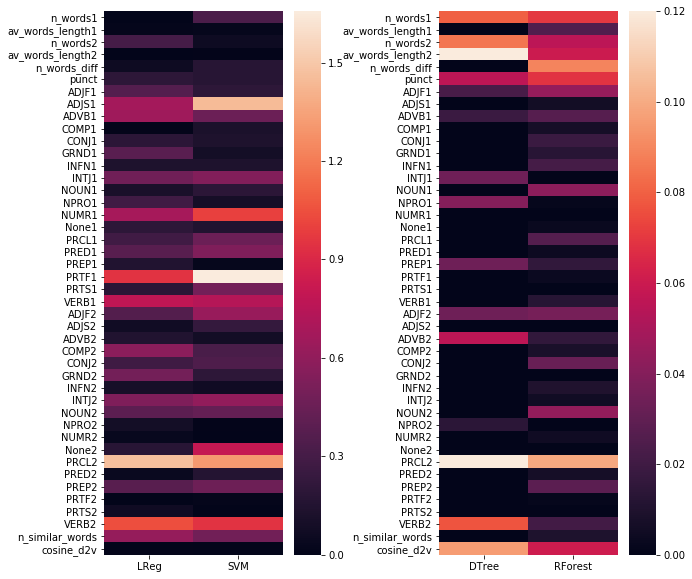

In [55]:
fig, (ax,ax2) = plt.subplots(ncols=2, figsize=(10,10))
fig.subplots_adjust(wspace=0.5)
sns.heatmap(features[['LReg', 'SVM']], cmap="rocket", ax=ax, cbar=True, vmin=0)
sns.heatmap(features[['DTree', 'RForest']], cmap="rocket", ax=ax2, cbar=True, vmax=0.12)
plt.show()

In [56]:
features

,LReg,DTree,RForest,SVM
n_words1,0.006433,0.080035,0.070077,0.323764
av_words_length1,0.015607,0.000000,0.025317,0.021880
n_words2,0.298930,0.085341,0.055466,0.061487
av_words_length2,0.002395,0.136853,0.060055,0.007624
n_words_diff,0.062449,0.000000,0.089215,0.174328
punct,0.194617,0.055797,0.068772,0.173632
ADJF1,0.367547,0.022774,0.044533,0.196908
ADJS1,0.678852,0.000000,0.005699,1.445136
ADVB1,0.659550,0.018310,0.027126,0.455026
COMP1,0.007468,0.000000,0.006732,0.121564


_Анна Полянская, НИУ ВШЭ, 2020_